$$\require{mhchem}$$       

# Homework 9
## Pengfei Cheng
## AndrewID: pengfeic

# Problem 1: Non-isothermal batch reactor design

The exothermic elementary liquid phase reaction
\begin{align}
\ce{A + B <->[k,K] C + D}\\
\end{align}
is carried out in a batch reactor with a cooling coil to keep the reactor isothermal at 40 C. The reactor is initially charged with equal concentrations of A and B and no C or D, $C_{A0}=C_{B0}=2$mol/L.  

$k=0.1$ L/mol/min at 40 C, $K=2$ at 40 C

$\Delta H_R=-20$ kcal/mol A at 40 C

Partial molar heat capacities $C_{pA}=C_{pB}=C_{pC}=C_{pD}=20$cal/mol/K

Activation energy for the reaction $E_a=1000 cal/mol/K$. 

Reactor volume 1200 L

## Part A
How long does it take to reach 50% conversion? Also show a plot of concentration of all species vs time.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
from pycse import odelay

It takes 6.23 min to reach 50% conversion.


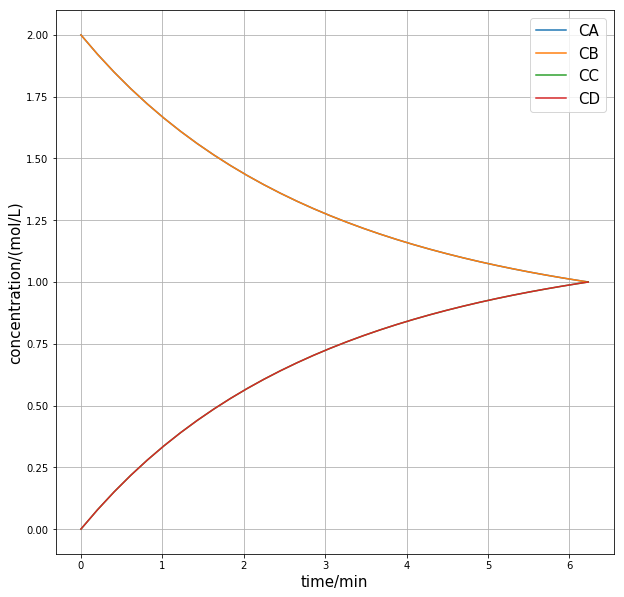

In [127]:
C0 = [2, 2, 0, 0] # M
k = 0.1 # L/mol/min
K = 2
dH_R = -20 # kcal/mol
C_pA = C_pB = C_pC = C_pD = 20e-3 # kcal/mol/K
Ea = 1 # kcal/mol/K
V = 1200 # L

sc = [-1, -1, 1, 1] # stoichiometric coefficients

def dCdt (C, t):
    CA, CB, CC, CD = C
    
    r = k * (CA * CB - CC * CD / K)
    
    return np.dot(sc, r)

def event(C, t):
    CA, CB, CC, CD = C
    conv = (C0[0] - CA)/C0[0]
    value = conv - 0.5
    isterminal = 1
    direction = 0
    return value, isterminal, direction

tspan = np.linspace(0, 10) #min

t, C, te, Ce, ie = odelay(dCdt, C0, tspan, [event])

print('It takes {:0.2f} min to reach 50% conversion.'.format(te[0]))

plt.figure(figsize=(10, 10))
plt.plot(t, C)
plt.legend(['CA', 'CB', 'CC', 'CD'], fontsize = 15)
plt.xlabel('time/min', fontsize = 15)
plt.ylabel('concentration/(mol/L)', fontsize = 15)
plt.grid()
plt.show()

## Part B
What is the total amount of heat (kcal) that must be removed by the cooling coil when the conversion is reached?

\begin{equation*}
    \dot Q = - \Delta H_R r V
\end{equation*}

In [93]:
Q0 = 0 # kcal
Q_C0 = [Q0] + C0

def dQdt(Q_C, t):
    Q, CA, CB, CC, CD = Q_C
    
    r = k * (CA * CB - CC * CD / K)
    
    dQdt = - dH_R * r * V
    
    return [dQdt, -r, -r, r, r]

tspan = np.linspace(0, te)

sol = odeint(dQdt, Q_C0, tspan)
Q_total = sol[-1][0]
print('{:1.2f} kcal of heat must be removed when the conversion is 0.5.'.format(Q_total))

24000.01 kcal of heat must be removed when the conversion is 0.5.


## Part C
What is the maximum rate at which heat must be removed by the cooling coil, and at what time does this occur?

$\dot Q = - \Delta H_R r V$, so $|\dot Q|$ is maximized when $r$ is at the maximum.
From the plot in Part A, it is obvious that $r$ reaches its maximum when $t = 0$.

In [126]:
CA0, CB0 = C0[:2]
r0 = k * CA0 * CB0

Q_dot_max = - dH_R * r0 * V

print('At time = 0, Q_dot reaches its maximum, {:1.2f} kcal/min.'.format(Q_dot_max))

At time = 0, Q_dot reaches its maximum, 9600.00 kcal/min.


## Part D
Now consider a non-isothermal version of this reactor.  There is a cooling bath around the reactor with a total heat transfer coefficient $Ua=300$ kcal/L/min. The reactor starts at 40 C. What is the maximum temperature $T_0$ that you can keep the cooling bath such that the temperature in the batch reactor rises no higher than 60C?

\begin{equation*}
    \frac{dT}{dt} =  \frac{-\Delta H_R r V_r + Ua(T_{coolant} - T)}{ \sum n_i C_{p,i} } 
\end{equation*}

In [129]:
Ua = 300 # kcal/L/min
T0 = 40 + 273
T_C0 = [T0] + C0
R = 1.985e-3 # kcal/K/mol
tspan = np.linspace(0, 20, 10000)

def dTdt(T_C, t, T_cool):
    T, CA, CB, CC, CD = T_C
    
    k_ = k * np.exp(- Ea / R * (1/T - 1/T0))
    K_ = K * np.exp(- dH_R / R * (1/T - 1/T0))
    
    r = k_ * (CA * CB - CC * CD / K_)
    
    dTdt = (- dH_R * r * V + Ua * (T_cool - T)) / (C_pA * CA * V + C_pB * CB * V + C_pC * CC * V + C_pD * CD * V)
    
    return [dTdt, -r, -r, r, r]

def find_T0(T_cool):
    T_C_sol = odeint(dTdt, T_C0, tspan, args = (T_cool,)).T
    T = T_C_sol[0]
    T_max = np.amax(T)
    return T_max - 60 - 273

T0_sol, = fsolve(find_T0, 30 + 273)
print('The maximum T0 for cooling bath is {:1.2f} C.'.format(T0_sol - 273))

The maximum T0 for cooling bath is 34.55 C.


# PBR with internal mass transfer and heat drops

You have a isomerization catalytic reactor with the following kinetics:
\begin{align*}
\ce{A + S <->[K_A] AS}\\
\ce{AS ->[k] BS}\\
\ce{BS -> B + S}
\end{align*}
The surface step is limiting and you derive the following rate law:
\begin{align*}
r= k \overline{c}_m \frac{K_A c_A}{1 + K_A c_A}
\end{align*}
The reactor is a 500 L CSTR with 5 kg of catalyst particles.  The catalyst particles are 20 mm diameter, the rate constant for the surface step is 100/s/g$_{cat}$, the activation energy for the surface step is $20$ kcal/mol, the heat of reaction for the first adsorption step is $\Delta H_R=-5$kcal/mol (assume temperature independent), the heat of reaction for the full reaction $\ce{A->B}$ is -10 kcal/mol, and the equilibrium coefficient at 200 C is 2. The specific heat of A and B are both 10 cal/molK. The diffusion coefficient at 200 C for A in the particle is 0.1 cm$^2/s$ at 200 C and scales with temperature as $D=D_0(T/T0)^{3/2}$. The pressure drop in the reactor is negligible. The reactor is fed with $4 mol/L$ A at 1 L/s at 200 C. The catalyst site density is $\bar{C_m}=10^{-2}$ mol/gcat. The reactor is adiabatic (no heat transfer). 

You may assume that the solution for a sphere applies $ \eta = \frac{1}{\Phi}  \left [\frac{1}{\tanh 3 \Phi} - \frac{1}{3 \Phi} \right]$, using the correct $\Phi$ for this problem / rate law.

## Part A
Calculate the exit concentration of the CSTR for an inlet feed at 200 C

In [133]:
V = 500 # L
m_cat = 5 # kg
d = 20e-3 # m
k0 = 100 # 1/s/g_cat
T0 = 473 # K
Tin = T0
Ea = 20 # kcal/mol
dH_R = 5 # kcal/mol
KA0 = 2 # at 200 C
C_pA = C_pB = 10e-3 # kcal/mol/K
D0 = 0.1 # cm^2/s

CA0 = 4 # mol/L
nu = 1 # L/s
cm_bar = 1e-2 # mol/g_cat

R = 1.985e-3 # kcal/K/mol

a = d/6

def CSTR(Y):
    CA, T = Y
    
    k = k0 * np.exp( - Ea / R * (1/T - 1/T0))
    KA = KA0 * np.exp( - dH_R / R * (1/T - 1/T0))
    r = k * cm_bar * (KA * CA) / (1 + KA * CA)
    
    D = D0 * (T/T0) ** 1.5
    phi = KA * CA
    #Phi_bar = (k * cm_bar * a ** 2 / D) ** 0.5
    Phi = phi / (1 + phi) * (k * cm_bar * KA * a ** 2 / (2 * (phi - np.log(1 + phi)) *D)) ** 0.5
    
    eta = 1 / Phi * (1 / np.tanh(3 * Phi) - 1 / (3 * Phi))
    
    re = r * eta
    
    y1 = CA0 * nu - CA * nu - re * V
    y2 = (CA0 * nu * C_pA) * (Tin - T) - dH_R * re *V
    
    return [y1, y2]

sol = fsolve(CSTR, [4, 400])
CA_exit = sol[0]
CB_exit = CA0 - CA_exit

print('CA_exit = {:1.2f}, CB_exit = {:1.2f}.'.format(CA_exit, CB_exit))

CA_exit = 3.18, CB_exit = 0.82.


## Part B
Calculate the exit concentration as a function of temperature of the inlet feed

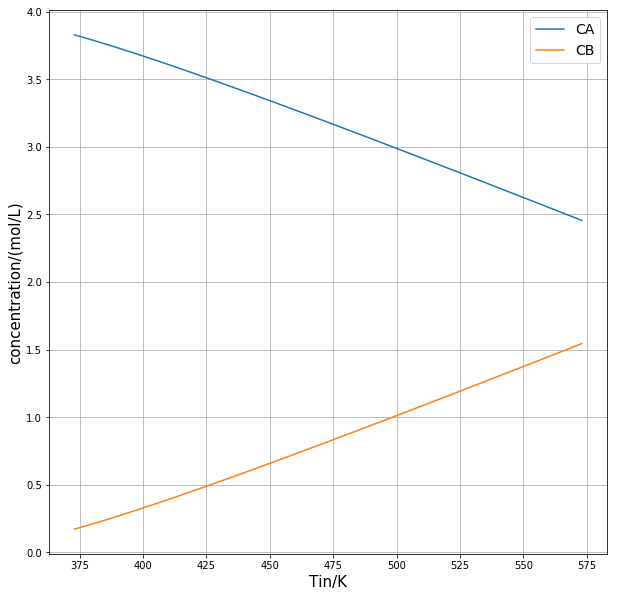

In [165]:
def CSTR_B(Y, T_in):
    CA, T = Y
    
    k = k0 * np.exp( - Ea / R * (1/T - 1/T0))
    KA = KA0 * np.exp( - dH_R / R * (1/T - 1/T0))
    r = k * cm_bar * (KA * CA) / (1 + KA * CA)
    
    D = D0 * (T/T0) ** 1.5
    phi = KA * CA
    
    Phi = phi / (1 + phi) * (k * cm_bar * KA * a ** 2 / (2 * (phi - np.log(1 + phi)) *D)) ** 0.5
    
    eta = 1 / Phi * (1 / np.tanh(3 * Phi) - 1 / (3 * Phi))
    
    re = r * eta
    
    y1 = CA0 * nu - CA * nu - re * V
    y2 = (CA0 * nu * C_pA) * (T_in - T) - dH_R * re *V
    
    return [y1, y2]

Y0 = [3, 400]
Y_sol = []

Tinspan = np.linspace(373, 573, 100)
for T_in_ in Tinspan:
    Y = fsolve(CSTR_B, Y0, args = (T_in_, ))
    Y_sol += [Y]

CA = np.array(Y_sol).T[0]
CB = CA0 - CA

plt.figure(figsize = (10, 10))
plt.plot(Tinspan, CA, Tinspan, CB)
plt.xlabel('Tin/K', fontsize = 15)
plt.ylabel('concentration/(mol/L)', fontsize = 15)
plt.grid()
plt.legend(['CA', 'CB'], fontsize = 14)
plt.show()